In [5]:
# Import necessary libraries
import pandas as pd              # Data manipulation library
import numpy as np               # Numerical operations library
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns            # Statistical data visualization library
import psycopg2                  # PostgreSQL adapter for Python

from dotenv import load_dotenv   # Load environment variables from a file
import os                        # Operating system module

from sqlalchemy import create_engine  # SQL toolkit and Object-Relational Mapping (ORM)

# Data Visualization
import statsmodels.formula.api as smf                # Statistical models library
from statsmodels.tsa.seasonal import seasonal_decompose  # Seasonal decomposition library
from scipy.ndimage import gaussian_filter          # Multi-dimensional image processing library
from calendar import monthrange, month_name        # Calendar-related functions

# More plotting libraries
import matplotlib.patches as patches

# Time Series Analysis libraries
from sklearn.metrics import mean_squared_error     # Mean squared error metric
from math import sqrt                             # Square root function
from statsmodels.tsa.stattools import adfuller, kpss  # Augmented Dickey-Fuller and Kwiatkowski-Phillips-Schmidt-Shin tests
from statsmodels.tsa.arima_model import ARIMA      # Autoregressive Integrated Moving Average model
from statsmodels.graphics.tsaplots import plot_pacf  # Partial autocorrelation function plot

# Auto ARIMA library
from pmdarima.arima import auto_arima

# More time series visualization libraries
import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

# Set seaborn style and color palette
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': 'white', 'grid.color': '.8'}
)
NF_ORANGE = '#ff5a36'
NF_BLUE = '#163251'
cmaps_hex = ['#193251','#FF5A36','#696969', '#7589A2','#FF5A36', '#DB6668']
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

# Display plots inline in Jupyter Notebook
%matplotlib inline

# Register matplotlib converters for better datetime plotting
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Set default figure size and DPI for matplotlib
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100


In [7]:
# Load environment variables from a file
load_dotenv()

# Retrieve the value of the "DB_STRING" environment variable
DB_STRING = os.getenv("DB_STRING")

# Create a database engine using the retrieved database connection string
db = create_engine(DB_STRING)


In [8]:
# SQL query string to set the schema and select all columns from the "prognostica_daten_kunden" table
query_string = """
SET SCHEMA 'takemehome';
SELECT *
FROM prognostica_daten_kunden pdk"""

# SQL query string to set the schema and select all columns from the "prognostica_afo" table
query_string_afo = """
SET SCHEMA 'takemehome';
SELECT *
FROM prognostica_afo pa
"""

# Use pandas to execute the SQL query and read the result into a DataFrame for "prognostica_daten_kunden"
df = pd.read_sql(query_string, db)

# Use pandas to execute the SQL query and read the result into a DataFrame for "prognostica_afo"
df_afo = pd.read_sql(query_string_afo, db)

# Display the resulting DataFrame for "prognostica_afo"
df_afo


,date,value
0,01.07.2005,"100,18"
1,01.08.2005,"100,29"
2,01.09.2005,"100,44"
3,01.10.2005,"100,51"
4,01.11.2005,"100,51"
...,...,...
112,01.11.2014,"100,56"
113,01.12.2014,"100,44"
114,01.01.2015,"100,3"
115,01.02.2015,"100,16"


In [9]:
# Replace commas with dots in the 'value' column and convert it to a float data type
df_afo['value'] = df_afo['value'].str.replace(',','.').astype(float)

# Convert the 'date' column to a datetime format, extract the month, and store it as a period
df_afo['month'] = pd.to_datetime(df_afo['date'], format='%d.%m.%Y').dt.to_period('M')

# Drop the 'date' column from the DataFrame
df_afo.drop(columns=['date'], inplace=True)

# Rename the columns to 'sales' and 'month'
df_afo.columns = ['sales', 'month']


In [10]:
df_afo

,sales,month
0,100.18,2005-07
1,100.29,2005-08
2,100.44,2005-09
3,100.51,2005-10
4,100.51,2005-11
...,...,...
112,100.56,2014-11
113,100.44,2014-12
114,100.30,2015-01
115,100.16,2015-02


## Task 1 - "Data Preparation"
- All customers with the suffix "DEK" must be removed.
- The remaining customer values must be aggregated on a monthly basis, so that there is only one total value per month, which consists of the sum of all remaining customer values.

In [11]:
# Remove all rows in the DataFrame where the 'customer' column ends with '_DEK'
df = df[~df['customer'].str.endswith('_DEK')]


In [12]:
# Convert the 'date' column from a string to a datetime object using the specified format
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

# Transform the 'date' column to a month period and create a new column 'month'
df['month'] = df['date'].dt.to_period('M')

# Extract the year from the 'month' column and create a new column 'year'
df['year'] = df['month'].dt.year

# Drop the 'date' and 'customer' columns from the DataFrame
df.drop(columns=['date', 'customer'], inplace=True)


In [13]:
# Sort the DataFrame 'df' based on the values in the 'month' column in ascending order
df.sort_values(by=['month'], inplace=True)

# Display the sorted DataFrame
df


,value,month,year
0,121.928864,2005-07,2005
2,643.681535,2005-07,2005
3,467.995513,2005-07,2005
5,1047.027469,2005-07,2005
7,286.501237,2005-07,2005
...,...,...,...
978,1569.405639,2015-02,2015
982,790.321432,2015-03,2015
980,355.082649,2015-03,2015
981,814.300925,2015-03,2015


<Axes: xlabel='month'>

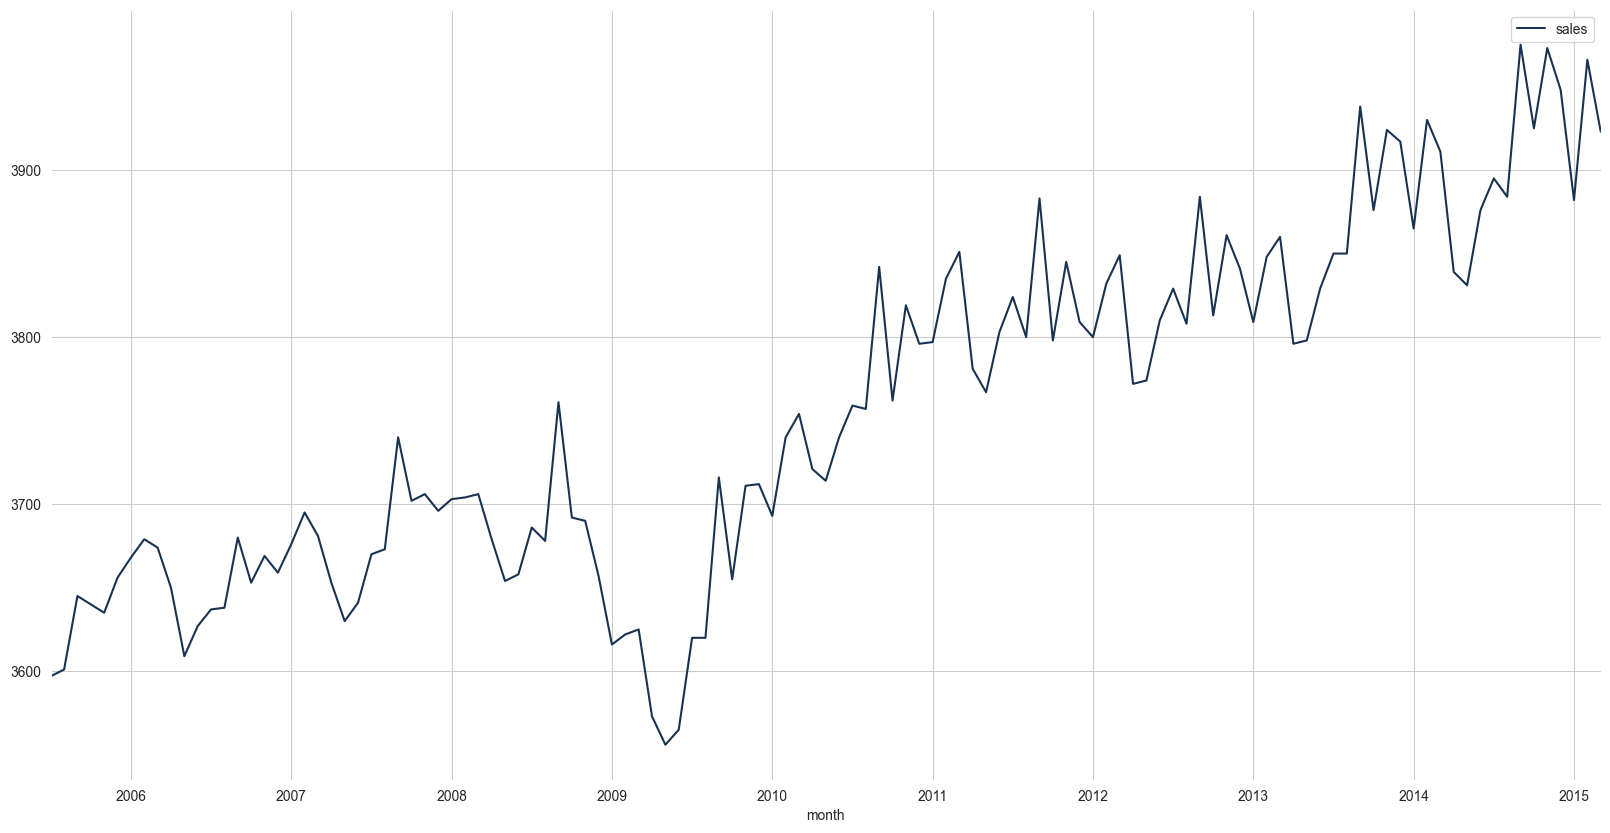

In [14]:
# Group the DataFrame 'df' by 'month' and 'year', summing up the values, and reset the index
df_agg = df.groupby(['month', 'year']).sum().reset_index()

# Display the aggregated DataFrame
df_agg

# Rename the columns in the aggregated DataFrame to 'month', 'year', and 'sales'
df_agg.columns = ['month', 'year', 'sales']

# Create a line plot of 'sales' against 'month' in the aggregated DataFrame
# Set the plot size to (20, 10)
df_agg.plot(x='month', y='sales', kind='line', figsize=(20, 10))


In [15]:
df_agg

,month,year,sales
0,2005-07,2005,3597.0
1,2005-08,2005,3601.0
2,2005-09,2005,3645.0
3,2005-10,2005,3640.0
4,2005-11,2005,3635.0
...,...,...,...
112,2014-11,2014,3973.0
113,2014-12,2014,3948.0
114,2015-01,2015,3882.0
115,2015-02,2015,3966.0


In [16]:
# Create a copy of the DataFrame 'df_agg' and assign it to 'daily_data_df'
daily_data_df = df_agg.copy()

# Set the index of 'daily_data_df' to a PeriodIndex based on the 'month' column with a frequency of 'M' (monthly)
daily_data_df.set_index(pd.PeriodIndex(daily_data_df['month'], freq='M'), inplace=True)

# Display information about the 'daily_data_df' DataFrame
daily_data_df.info()


<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 117 entries, 2005-07 to 2015-03
Freq: M
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype    
---  ------  --------------  -----    
 0   month   117 non-null    period[M]
 1   year    117 non-null    int64    
 2   sales   117 non-null    float64  
dtypes: float64(1), int64(1), period[M](1)
memory usage: 3.7 KB


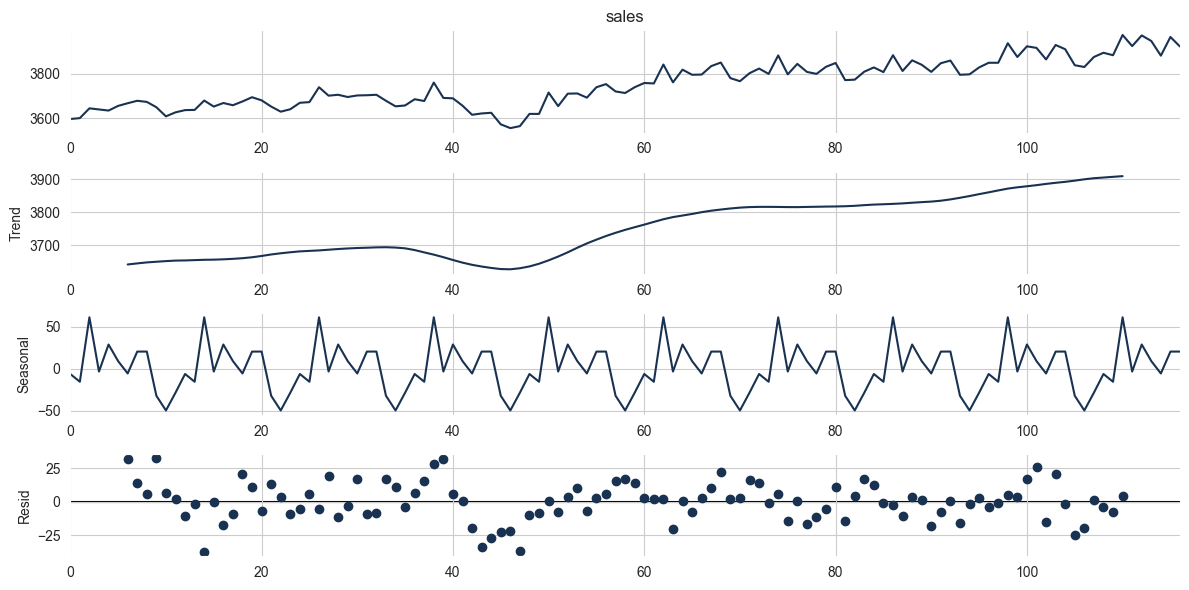

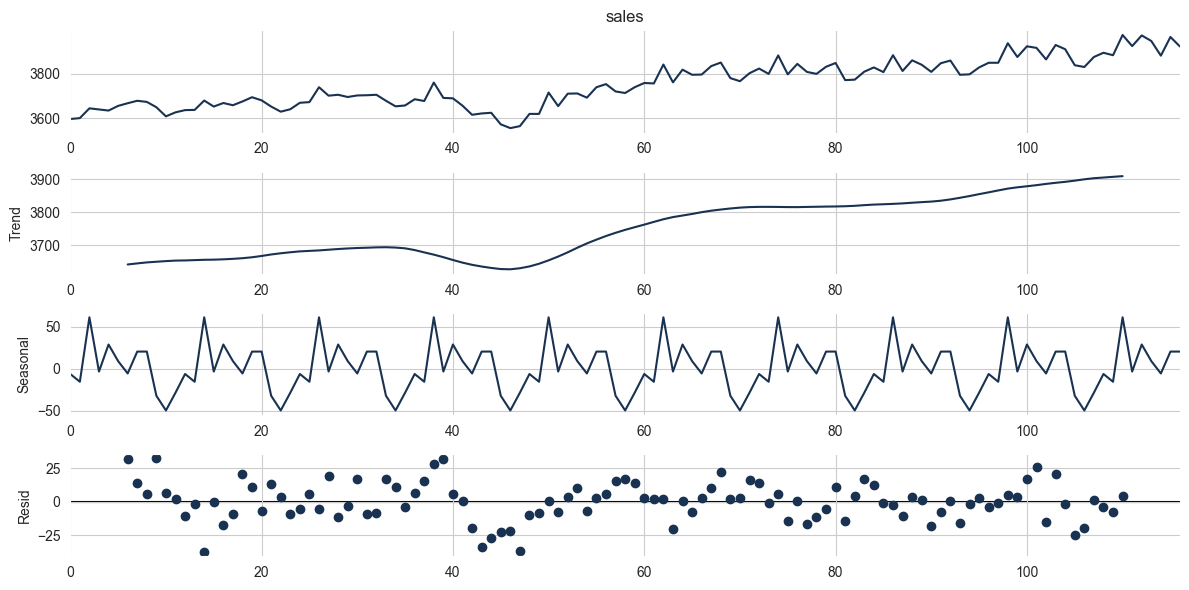

In [19]:
# Perform seasonal decomposition on the 'sales' column of the DataFrame 'df_agg'
# using an additive model and a seasonal period of 12
result = seasonal_decompose(df_agg['sales'], model='additive', period=12)

# Plot the decomposed components of the time series (trend, seasonal, and residual)
result.plot()


ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -1.372082
p-value: 0.595585
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 0.870470
p-value: 0.010000
----------------------------------------


/Users/stevenschepanski/Documents/SPICED/tutorials/week8/take-home-challenge/prognostica-revenue-prediction/.venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


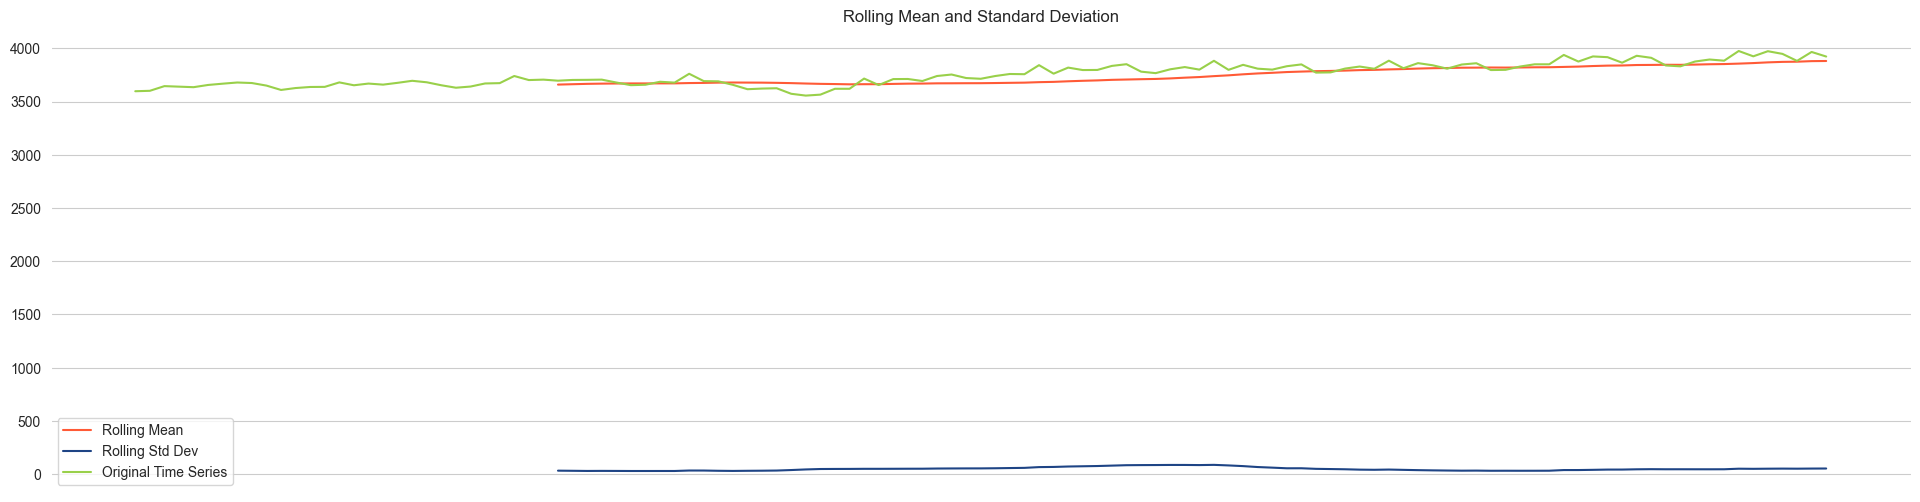

In [20]:
# Function to test stationarity of a time series and display relevant statistics and plots
def stationarity_test(stock_close_price):
    
    # Calculate rolling mean and rolling standard deviation with a window of 30
    rolling_mean = stock_close_price.rolling(30).mean()
    rolling_std_dev = stock_close_price.rolling(30).std()
    
    # Plot the rolling mean, rolling standard deviation, and the original time series
    plt.figure(figsize=(24, 6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label='Rolling Std Dev')
    plt.plot(stock_close_price, color='#99D04A', label='Original Time Series')
    plt.xticks([])  # Remove x-axis ticks for better visualization
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # Augmented Dickey-Fuller (ADF) test for stationarity
    print("ADF Test:")
    adf_test = adfuller(stock_close_price, autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----' * 10)
    
    # Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for stationarity
    print("KPSS Test:")
    kpss_test = kpss(stock_close_price, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----' * 10)

# Call the stationarity_test function with the 'sales' column of the DataFrame 'df_agg'
stationarity_test(df_agg['sales'])


In [21]:
# Display information about the DataFrame 'df_agg'
df_agg.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype    
---  ------  --------------  -----    
 0   month   117 non-null    period[M]
 1   year    117 non-null    int64    
 2   sales   117 non-null    float64  
dtypes: float64(1), int64(1), period[M](1)
memory usage: 2.9 KB


In [22]:
# Sort the DataFrame 'df_agg' based on the values in the 'month' column in ascending order
df_agg.sort_values(by=['month'], inplace=True)

# Display the sorted DataFrame 'df_agg'
df_agg


,month,year,sales
0,2005-07,2005,3597.0
1,2005-08,2005,3601.0
2,2005-09,2005,3645.0
3,2005-10,2005,3640.0
4,2005-11,2005,3635.0
...,...,...,...
112,2014-11,2014,3973.0
113,2014-12,2014,3948.0
114,2015-01,2015,3882.0
115,2015-02,2015,3966.0


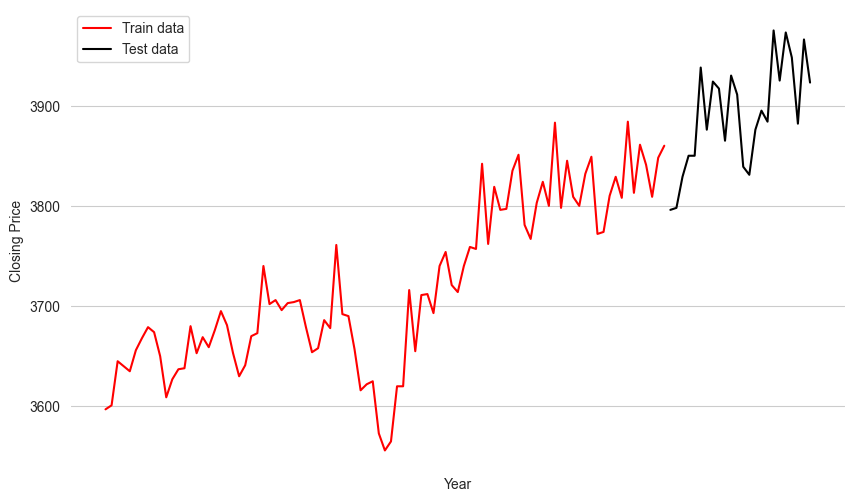

In [23]:
# Extract the 'sales' column from the DataFrame 'df_agg' and assign it to 'df_arima'
df_arima = df_agg['sales']

# Determine the index for splitting the data into training and testing sets (80% train, 20% test)
train_test_split_ratio = int(len(df_arima) * 0.8)

# Split the 'df_arima' into training and testing sets
train_data, test_data = df_arima[:train_test_split_ratio], df_arima[train_test_split_ratio:]

# Plot the training and testing sets
plt.figure(figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.xticks([])  # Remove x-axis ticks for better visualization
plt.plot(train_data, 'red', label='Train data')
plt.plot(test_data, 'black', label='Test data')
plt.legend();


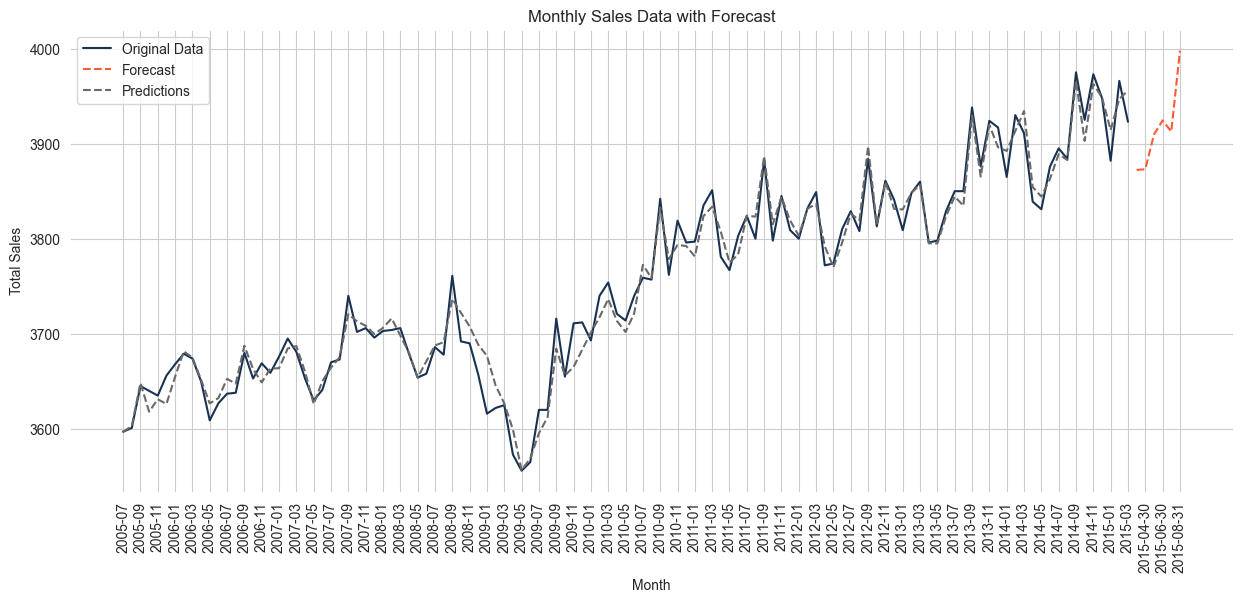

In [24]:
# Import the ExponentialSmoothing module from statsmodels for Holt-Winters Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Time series forecasting using Holt-Winters Exponential Smoothing
# You can choose a different forecasting model based on your data characteristics
model = ExponentialSmoothing(df_agg['sales'], trend='add', seasonal='add', seasonal_periods=12)
fit_model = model.fit()
forecast_values = fit_model.forecast(6)

# Create a DataFrame for the forecasted values
start_timestamp = df_agg['month'].max().to_timestamp()
forecast_dates = pd.date_range(start_timestamp, periods=7, freq='M')[1:]
forecast_df = pd.DataFrame({'month': forecast_dates, 'sales': forecast_values})

# Get predictions for the entire data set
predictions = fit_model.predict(start=0, end=len(df_agg)-1)

# Visualize the original data, the forecast, and the predictions
plt.figure(figsize=(15, 6))
plt.plot(df_agg['month'].astype(str), df_agg['sales'], linestyle='-', label='Original Data')
plt.plot(forecast_df['month'].astype(str), forecast_df['sales'], linestyle='--', label='Forecast')
plt.plot(df_agg['month'].astype(str), predictions, linestyle='--', label='Predictions')
plt.title('Monthly Sales Data with Forecast')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(range(0, len(df_agg)+len(forecast_df), 2), df_agg['month'][::2].astype(str).tolist()+forecast_df['month'][::2].astype(str).tolist(), rotation=90)
plt.legend()
plt.grid(True)
plt.show()


In [25]:
df_afo

,sales,month
0,100.18,2005-07
1,100.29,2005-08
2,100.44,2005-09
3,100.51,2005-10
4,100.51,2005-11
...,...,...
112,100.56,2014-11
113,100.44,2014-12
114,100.30,2015-01
115,100.16,2015-02


In [26]:
# Calculate the residual errors by subtracting the predicted values from the actual values
error = df_agg['sales'] - predictions

# Calculate and print the Root Mean Squared Error (RMSE) for the Holt-Winters Exponential Smoothing model
print('RMSE value for the Holt-Winters Exponential Smoothing model is: ', np.sqrt(np.mean(error**2)))

# Define adjustment parameters
min_index = 96
max_index = 101
adjustment_factor = 0.02  # Adjust as needed based on the specific relationship

# Modify the forecast based on the business climate index
for i, row in df_afo.iterrows():
    business_climate_index = row['sales']
    adjustment = (business_climate_index - min_index) * adjustment_factor
    adjustment = max(0, min(adjustment, 1))  # Ensure adjustment is between 0 and 1
    adjusted_predictions = predictions + adjustment * error



RMSE value for the Holt-Winters Exponential Smoothing model is :  16.0529528281219


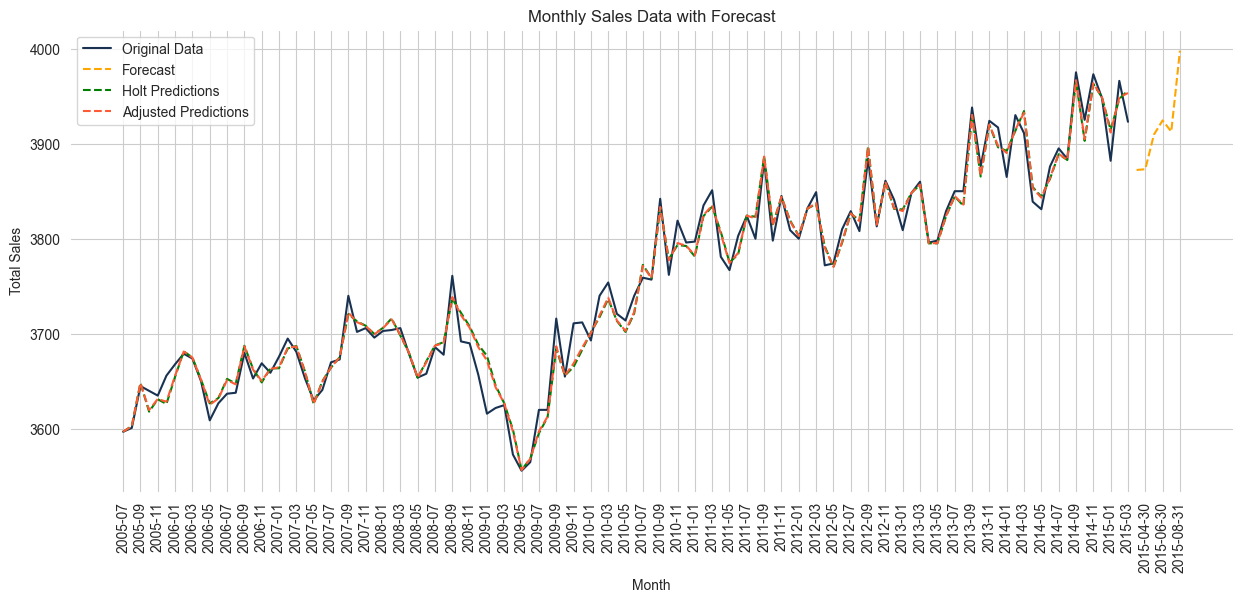

In [27]:
# Import the ExponentialSmoothing module from statsmodels for Holt-Winters Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Time series forecasting using Holt-Winters Exponential Smoothing
# You can choose a different forecasting model based on your data characteristics

# Create an ExponentialSmoothing model with additive trend, additive seasonality, and a seasonal period of 12 months
model = ExponentialSmoothing(df_agg['sales'], trend='add', seasonal='add', seasonal_periods=12)

# Fit the ExponentialSmoothing model to the historical sales data
fit_model = model.fit()

# Forecast the next 6 periods using the trained model
forecast_values = fit_model.forecast(6)

# Create a DataFrame for the forecasted values with corresponding dates
start_timestamp = df_agg['month'].max().to_timestamp()
forecast_dates = pd.date_range(start_timestamp, periods=7, freq='M')[1:]
forecast_df = pd.DataFrame({'month': forecast_dates, 'sales': forecast_values})

# Get predictions for the entire historical data set
predictions = fit_model.predict(start=0, end=len(df_agg)-1)

# Visualize the original data, the forecast, and the predictions using matplotlib

# Set up the figure size
plt.figure(figsize=(15, 6))

# Plot the original sales data in blue solid line
plt.plot(df_agg['month'].astype(str), df_agg['sales'], linestyle='-', label='Original Data')

# Plot the forecasted values in orange dashed line
plt.plot(forecast_df['month'].astype(str), forecast_df['sales'], linestyle='--', label='Forecast', color='orange')

# Plot the Holt predictions in green dashed line
plt.plot(df_agg['month'].astype(str), predictions, linestyle='--', label='Holt Predictions', color='green')

# Assuming 'adjusted_predictions' is a variable calculated in a previous code block
# Plot the adjusted predictions in a dashed line (style can be changed based on visualization preference)
plt.plot(df_agg['month'].astype(str), adjusted_predictions, linestyle='--', label='Adjusted Predictions')

# Set plot title and labels
plt.title('Monthly Sales Data with Forecast')
plt.xlabel('Month')
plt.ylabel('Total Sales')

# Set x-axis ticks for better readability
plt.xticks(range(0, len(df_agg)+len(forecast_df), 2), df_agg['month'][::2].astype(str).tolist()+forecast_df['month'][::2].astype(str).tolist(), rotation=90)

# Display legend
plt.legend()

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.show()


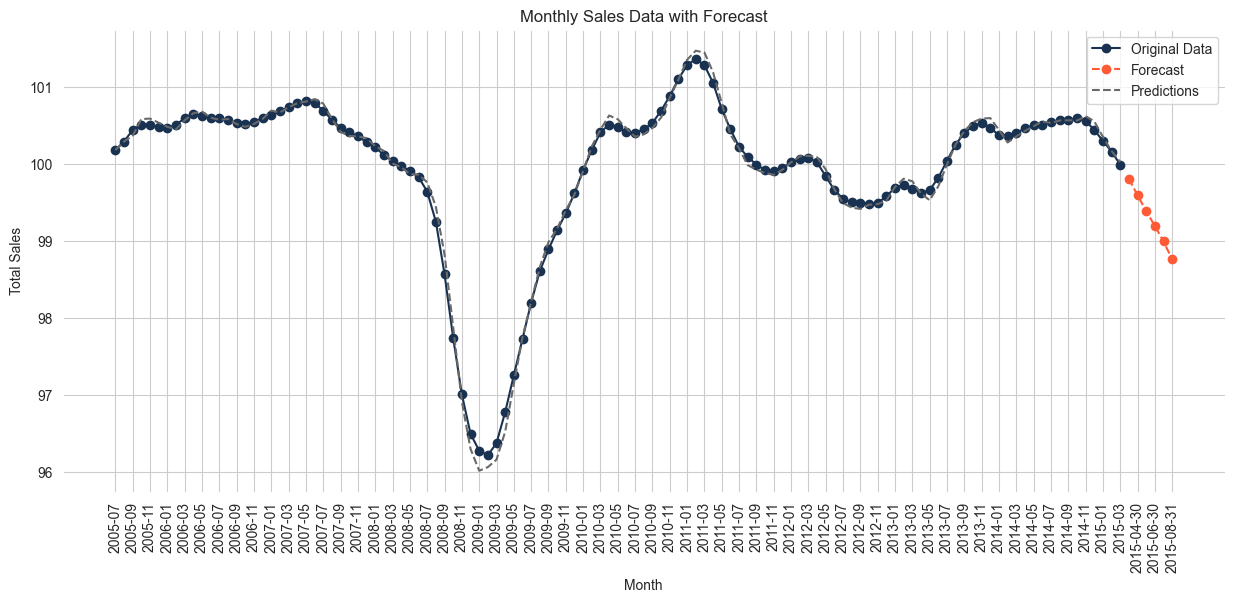

In [28]:
# Import the ExponentialSmoothing module from statsmodels for Holt-Winters Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Time series forecasting using Holt-Winters Exponential Smoothing
# You can choose a different forecasting model based on your data characteristics

# Create an ExponentialSmoothing model with additive trend, additive seasonality, and a seasonal period of 12 months
model = ExponentialSmoothing(df_afo['sales'], trend='add', seasonal='add', seasonal_periods=12)

# Fit the ExponentialSmoothing model to the historical sales data
fit_model = model.fit()

# Forecast the next 6 periods using the trained model
forecast_values = fit_model.forecast(6)

# Create a DataFrame for the forecasted values with corresponding dates
start_timestamp = df_afo['month'].max().to_timestamp()
forecast_dates = pd.date_range(start_timestamp, periods=7, freq='M')[1:]
forecast_df = pd.DataFrame({'month': forecast_dates, 'sales': forecast_values})

# Get predictions for the entire historical data set
predictions = fit_model.predict(start=0, end=len(df_afo)-1)

# Visualize the original data and the forecast using matplotlib

# Set up the figure size
plt.figure(figsize=(15, 6))

# Plot the original sales data with markers in blue solid line
plt.plot(df_afo['month'].astype(str), df_afo['sales'], marker='o', linestyle='-', label='Original Data')

# Plot the forecasted values with markers in orange dashed line
plt.plot(forecast_df['month'].astype(str), forecast_df['sales'], marker='o', linestyle='--', label='Forecast')

# Plot the predicted values in green dashed line
plt.plot(df_afo['month'].astype(str), predictions, linestyle='--', label='Predictions')

# Set plot title and labels
plt.title('Monthly Sales Data with Forecast')
plt.xlabel('Month')
plt.ylabel('Total Sales')

# Set x-axis ticks for better readability
plt.xticks(range(0, len(df_agg)+len(forecast_df), 2), df_agg['month'][::2].astype(str).tolist()+forecast_df['month'][::2].astype(str).tolist(), rotation=90)

# Display legend
plt.legend()

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.show()


In [30]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Time series forecasting using Holt-Winters Exponential Smoothing
# You can choose a different forecasting model based on your data characteristics

# Create an ExponentialSmoothing model with additive trend, additive seasonality, and a seasonal period of 12 months
model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=12)
fit_model = model.fit()

# Forecast the next 6 periods using the trained model
forecast_values = fit_model.forecast(6)

# Create a DataFrame for the forecasted values with corresponding dates
# Assuming 'train_data' has a datetime index, so 'month' is not a column but part of the index
start_timestamp = train_data.index.max().to_timestamp()
forecast_dates = pd.date_range(start_timestamp, periods=7, freq='M')[1:]
forecast_df = pd.DataFrame({'month': forecast_dates, 'sales': forecast_values})

# Visualize the original data and the forecast using matplotlib

# Set up the figure size
plt.figure(figsize=(15, 6))

# Plot the original sales data with markers in blue solid line
plt.plot(train_data.index.astype(str), train_data['sales'], marker='o', linestyle='-', label='Original Data')

# Plot the forecasted values with markers in orange dashed line
plt.plot(forecast_df['month'].astype(str), forecast_df['sales'], marker='o', linestyle='--', label='Forecast')

# Set plot title and labels
plt.title('Monthly Sales Data with Forecast')
plt.xlabel('Month')
plt.ylabel('Total Sales')

# Set x-axis ticks for better readability
plt.xticks(range(0, len(train_data) + len(forecast_df), 2), train_data.index[::2].astype(str).tolist() + forecast_df['month'][::2].astype(str).tolist(), rotation=90)

# Display legend
plt.legend()

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.show()


AttributeError: 'int' object has no attribute 'to_timestamp'

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=918.207, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=932.631, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=916.381, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=917.290, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=931.160, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=918.211, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=915.647, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=917.553, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=917.558, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=916.949, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=919.503, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.510 seconds
                               SARIMAX Results                                
Dep. Variable:           

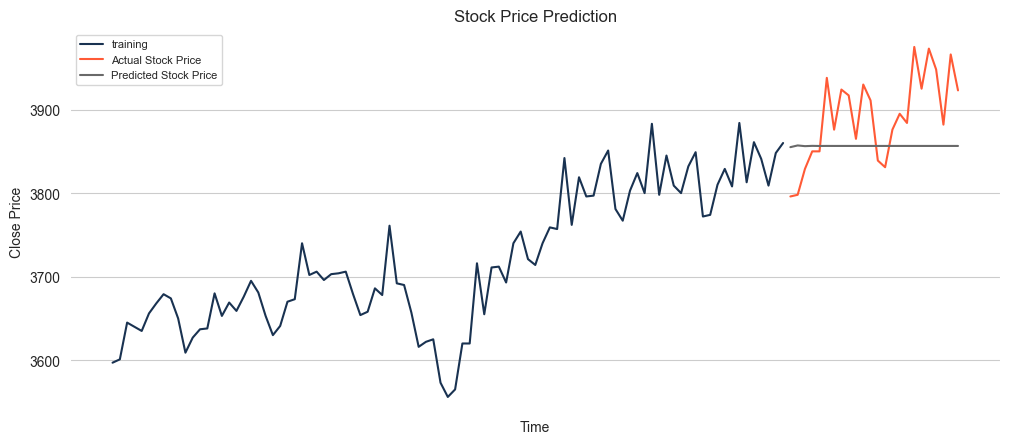

In [31]:
# Auto ARIMA Method
# Use auto_arima to automatically select the optimal ARIMA model parameters
arima_model = auto_arima(train_data,
                      start_p=1, start_q=1,
                      max_p=20, max_q=20,
                      test='adf',        
                      trace=True,
                      alpha=0.05,
                      scoring='mse',
                      suppress_warnings=True,
                      seasonal=True,
                      stationary=False
                      )

# Fit the final ARIMA model with the selected order
fitted_model = arima_model.fit(train_data) 
print(fitted_model.summary())

# Forecasting values
# Predict future values using the fitted ARIMA model
forecast_values = fitted_model.predict(len(test_data), alpha=0.05) 
fcv_series = forecast_values

# Plot the predicted stock price, original price, and training data
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Stock Price')
plt.plot(fcv_series, label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.xticks([])  # Hide x-axis ticks for better visualization
plt.legend(loc='upper left', fontsize=8)

# Evaluate the model by calculating RMSE
rms_auto_arima = sqrt(mean_squared_error(test_data.values, fcv_series))
print("Auto-Arima RMSE :- " + str(round(rms_auto_arima, 3)))

# Save the plot if needed
# plt.savefig("visualisations/Stock_ARIMA.png",dpi=300)

# Display the plot
plt.show()
